In [14]:
# Import
from Diffusion import *
from utils import makedir
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [15]:
# Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
local_storage_dir = "/home/md775/LocalStorage/MLProjects/Diffusion/" # Change this to your storage directory
dataset_dir = local_storage_dir + "Datasets/Galaxies/images"
checkpoint_dir = local_storage_dir + "Checkpoints/galaxies/"
log_dir = local_storage_dir + "Logs/Galaxy/"
gif_dir = os.getcwd() + "/gifs/"
makedir(checkpoint_dir)
makedir(log_dir)
makedir(gif_dir)
num_channels = 3 # RGB
num_timesteps = 2000 # Number of timesteps of the diffusion process
beta_min = 1e-6
beta_max = 0.99
image_size = 64
batch_size = 32
max_dataset_size = -1 # Set to -1 to use the entire dataset

In [16]:
# Load Dataset
class ImageDataset(Dataset):
    def __init__(self, filenames, dataset_dir, load_all=False, transform=None):
        self.filenames = filenames
        self.dataset_dir = dataset_dir
        self.transform = transform
        if load_all:
            self.images = [read_image(os.path.join(dataset_dir, filename)) for filename in filenames]
            if self.transform:
                self.images = [self.transform(image) for image in self.images]
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        if hasattr(self, 'images'):
            image = self.images[idx]
        else:
            image = read_image(os.path.join(self.dataset_dir, self.filenames[idx]))
            if self.transform:
                image = self.transform(image)
        return image
    
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(90),
    transforms.CenterCrop(256),
    transforms.Resize((image_size, image_size), antialias=True),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  
])


filenames = os.listdir(dataset_dir)
filenames = [filename for filename in filenames if filename.endswith(".jpg")][:max_dataset_size]
dataset = ImageDataset(filenames, dataset_dir, load_all=False, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=24, pin_memory=True)

In [17]:
# Create diffusion model
DiffusionModel = Diffusion(
    image_size=image_size,
    num_channels = num_channels,
    num_timesteps=num_timesteps,
    beta_min=beta_min,
    beta_max=beta_max,
    beta_schedule="cosine",
    batch_size=batch_size,
    device=device
)

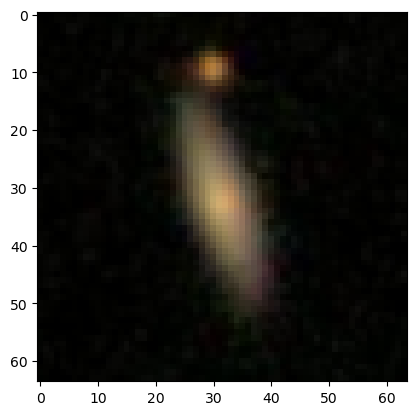

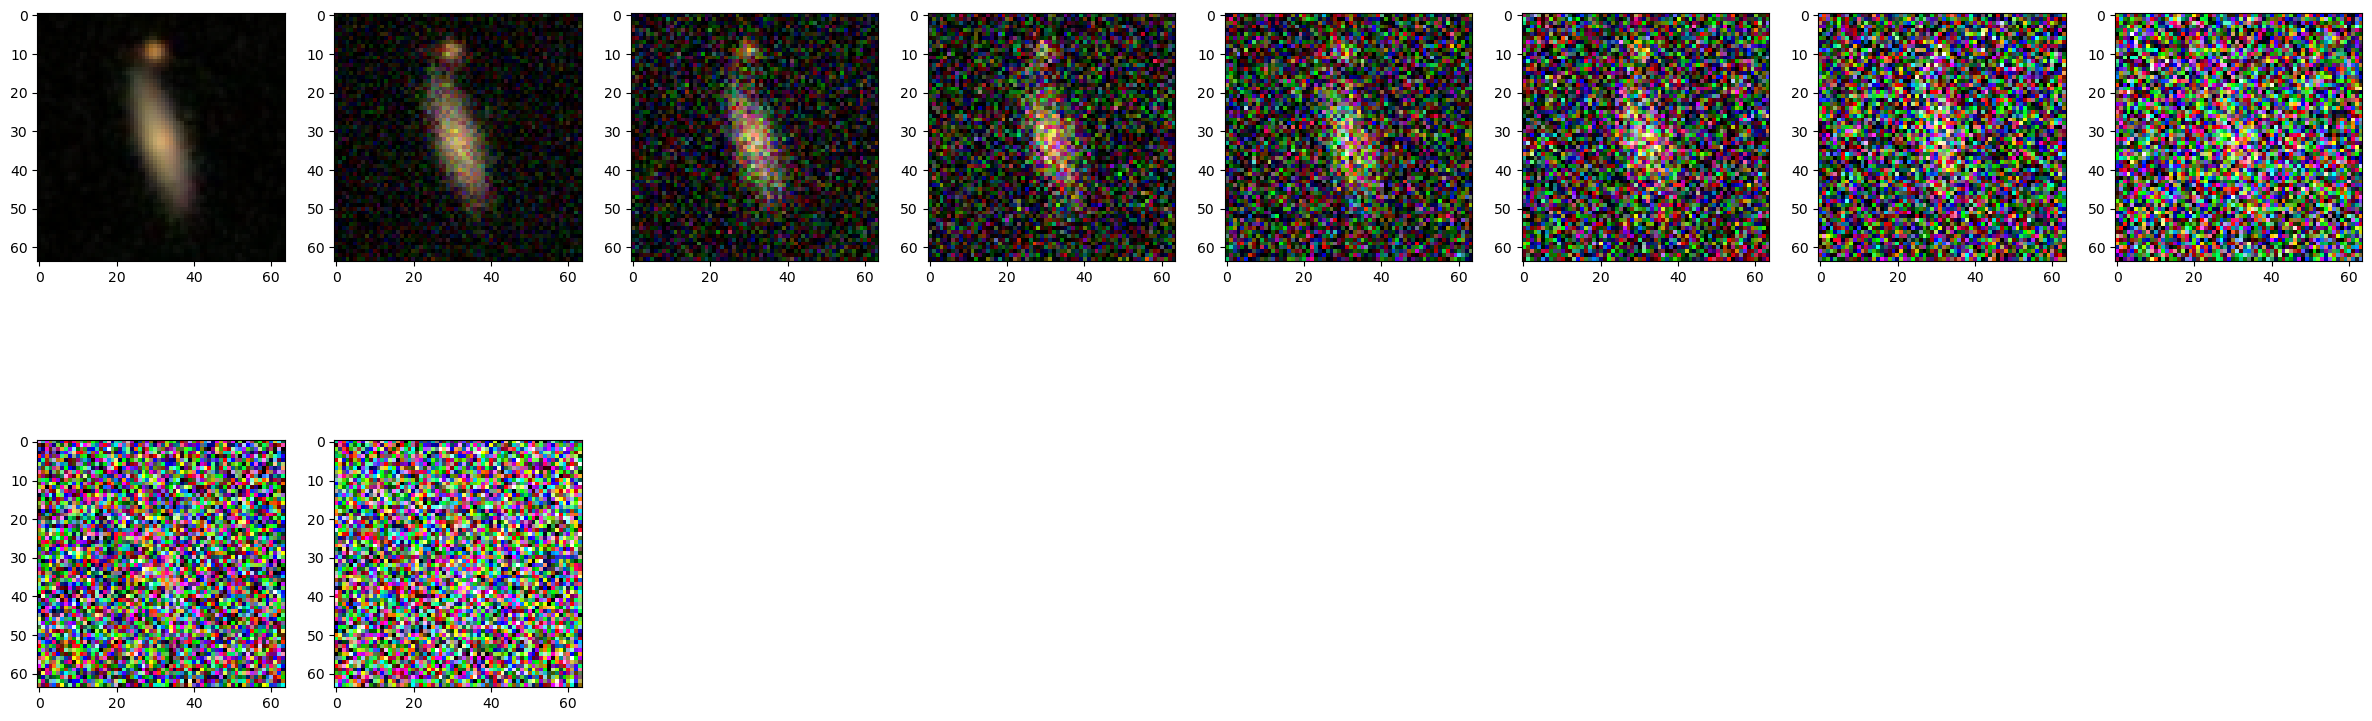

In [18]:
# Visualize forward process
def image_from_tensor(tensor):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: t.clamp(-1, 1)),
        transforms.Lambda(lambda t: 255 * (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
    ])
    return reverse_transforms(tensor)

initial_tensor = next(iter(dataloader)).to(device)
plt.imshow(image_from_tensor(initial_tensor[0]))

plt.figure(figsize=(30,60))
num_images = 10
stepsize = int(num_timesteps/num_images)

for idx in range(0, num_timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(int(num_images+1/8)+1, 8, int(idx/stepsize) + 1)
    tensor, noise = DiffusionModel.forward_process(initial_tensor[0,None], t)
    plt.imshow(image_from_tensor(tensor[0]), vmin=0, vmax=255)

In [21]:
# Create Unet model
model = DiffusionModel.create_model(
    num_init_ch=128,
    num_downsamples=4,
    num_mid_convs=1
    )
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, last_epoch=-1, verbose=False)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Number of parameters:  235536387


In [20]:
# Training
def loss_fn(true,pred):
    return F.mse_loss(true, pred) + F.l1_loss(true, pred)

load_from_checkpoint = False
if load_from_checkpoint:
    DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model, optimizer, lr_scheduler)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
DiffusionModel.train_model(
    epochs=40,
    data_loader=dataloader,
    model=model,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    loss_function=loss_fn,
    checkpoint_dir=checkpoint_dir,
    checkpoint_interval=1,
    log_dir=log_dir+timestamp
    )

  3%|▎         | 207/7607 [00:21<12:49,  9.62it/s, Epoch:=1, LR:=0.000902, Loss:=0.0821] 


KeyboardInterrupt: 

In [ ]:
# Sample from model
DiffusionModel.load_from_checkpoint(checkpoint_dir+"model_min_loss.pt", model)
tensor_sample = DiffusionModel.sample(num_images=1, variance_coeff=1)

1999it [00:13, 144.33it/s]


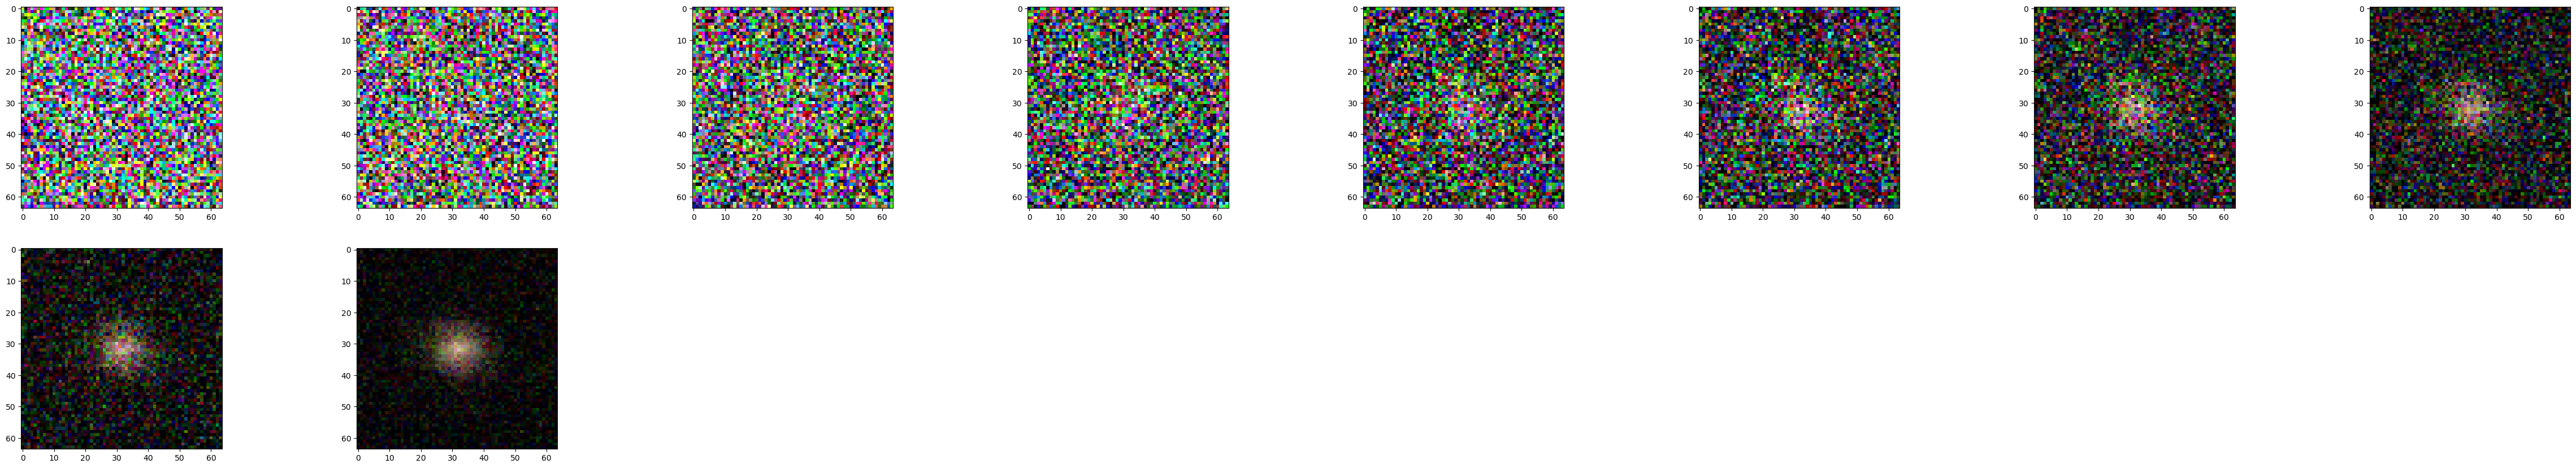

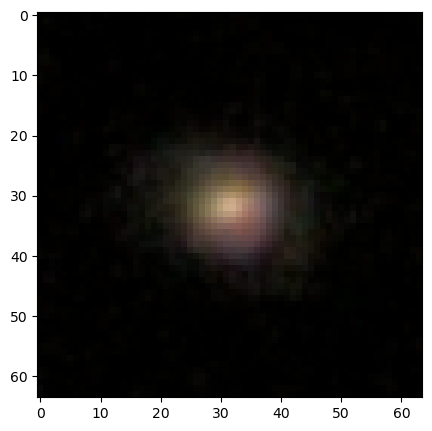

In [22]:
# Visualize reverse process
plt.figure(figsize=(60,60))
num_images = 10
stepsize = int(num_timesteps/num_images)
for i, tensor in enumerate(tensor_sample):
    if i % stepsize == 0:
        plt.subplot(int(num_images+1/8)+1, 8, int(i/stepsize) + 1)
        plt.imshow(image_from_tensor(tensor))
plt.figure(figsize=(5,5))
plt.imshow(image_from_tensor(tensor_sample[-1]))

In [ ]:
# Create gif
from PIL import Image
images = []
num_images = 200
stepsize = int(num_timesteps/num_images)
for t,tensor in enumerate(tensor_sample):
    if t % stepsize == 0:
        image_array = image_from_tensor(tensor).astype(np.uint8)
        image = Image.fromarray(image_array).convert('RGB')
        images.append(image)
images[0].save(gif_dir, save_all=True, append_images=images[1:], duration=50)